This script contains an example of MESMER-M-TP. The steps for working with MESMER-M-TP are the following
i. 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
import matplotlib.pyplot as plt

In [4]:
import pathlib

import numpy as np
import xarray as xr

import mesmer

## Functions 

In [ ]:
def converting_precipitation(pr_in_kgms, n_digits=10):
    """
    precipitation data from ESMs does usually not contain a cut-off value
    therefore, the models usually do not output zero-percipitation, but rather
    very small residual values and sometimes also very small negative values.
    This function converts precipitation from kg/m^2/s to mm/day andapplies
    a cut-off to set ver small precipitaiton values to zero.

    Parameters
    ----------
    pr_in_kgms: ndarray of arbitrary shape
        Precipitation data in kg/m^2/s
    n_digits: int
        number of digits behind the . to keep, precipitaiton is rounded and small
        values are rounded to 0

    Returns
    -------
    pr_in_mm : ndarray with same shape as pr_in_kgms
        Precipitation data in mm/day rounded s.t. only n digits after . are kept
    """

    pr_in_mm = pr_in_kgms * 86400
    # size                                    = len(pr_in_mm[pr_in_mm < 1*10**(-10)])
    pr_in_mm[pr_in_mm < 1 * 10 ** (-10)] = 1 * 10 ** (-n_digits)
    pr_in_mm = np.round(pr_in_mm, n_digits)
    return pr_in_mm

In [ ]:
# functionalities
def load_training_data(
    tas_hist_mon,
    tas_proj_mon,
    pr_hist_mon,
    pr_proj_mon,
    REFERENCE_PERIOD,
    THRESHOLD_LAND,
):
    tas_mon = xr.open_mfdataset(
        [tas_hist_mon, tas_proj_mon],
        combine="by_coords",
        use_cftime=True,
        combine_attrs="override",
        data_vars="minimal",
        compat="override",
        coords="minimal",
        drop_variables=["height", "file_qf"],
    ).load()

    # data preprocessing
    # create global mean tas anomlies timeseries
    tas_mon = mesmer.grid.wrap_to_180(tas_mon)
    # convert the 0..360 grid to a -180..180 grid to be consistent with legacy code

    ref = (
        tas_mon.groupby("time.year")
        .mean()
        .sel(year=REFERENCE_PERIOD)
        .mean("year", keep_attrs=True)
    )
    tas_mon = tas_mon - ref

    # create local gridded tas data
    def mask_and_stack(ds, threshold_land):
        ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
        ds = mesmer.mask.mask_antarctica(ds)
        ds = mesmer.grid.stack_lat_lon(ds)
        return ds

    tas_stacked_mon = mask_and_stack(tas_mon, threshold_land=THRESHOLD_LAND)

    pr_mon = xr.open_mfdataset(
        [pr_hist_mon, pr_proj_mon],
        combine="by_coords",
        use_cftime=True,
        combine_attrs="override",
        data_vars="minimal",
        compat="override",
        coords="minimal",
        drop_variables=["height", "file_qf"],
    ).load()

    # data preprocessing
    # create global mean tas anomlies timeseries
    pr_mon = mesmer.grid.wrap_to_180(pr_mon)
    pr_stacked_mon = mask_and_stack(pr_mon, threshold_land=THRESHOLD_LAND)

    pr_stacked_mon["pr"].data = converting_precipitation(pr_stacked_mon["pr"].data)

    return (tas_stacked_mon, pr_stacked_mon)

In [ ]:
# not sure where this function belong thematically
from sklearn.metrics.pairwise import haversine_distances


def get_closest_locations(gridcells, n_closest=150):
    """
    Given an array of (lat, lon) coordinates, this function computes the pairwise distance
    between all coordinate locations in the array and then returns an array
    of indices that gives the indices of the n_closest locations

    Parameters
    ----------
    coordinate_path: str or Path
        String or pahtlib.Path object pointing to an .npy file that contains an array of shape (n_locations, 2)
        tghat contains (lat, lon) coordinates for all n_locations
    n_closest: int
        number of closest locations to compute

    Returns
    -------
    selected_loc_: list of ndarrays
        Contains the indices of the n_closest coordinates for each location. That is, for the location
        with index i, i.e. coords[i], the coordinates of the n_closest locations are
        given by coords[selected_loc_[i]]

    """
    lats = gridcells["lat"].values
    lons = gridcells["lon"].values
    n_gridcells = len(lats)
    coords = np.array([[lats[i], lons[i]] for i in range(n_gridcells)])
    dist = (
        haversine_distances(np.pi / 180 * coords, np.pi / 180 * coords) * 6371
    )  # *6371000/1000  to conver to km
    selected_loc_ = [np.argsort(dist[j, :])[:n_closest] for j in range(n_gridcells)]
    locations = xr.DataArray(
        selected_loc_,
        dims=["gridcell", "closest_gridcells"],
        coords={
            "gridcell": gridcells.values,
            "closest_gridcells": np.arange(n_closest),
        },
    )
    # selected_loc      = [np.argwhere(dist[j,:] <= 3500).flatten() for j in range(n_index)] # for computing based on a radius; produces uneven results bc of missing values over ocean
    return locations

## Config

In [8]:
# define config values
THRESHOLD_LAND = 1 / 3

REFERENCE_PERIOD = slice("1850", "1900")

HIST_PERIOD = slice("1850", "2014")
PROJ_PERIOD = slice("2015", "2100")

LOCALISATION_RADII = range(1750, 2001, 250)

n_closest = 10
n_cov = 1 + 2 * n_closest

esm = "IPSL-CM6A-LR"
scenario = "ssp585"
run_id_training = "r1i1p1f1"
test_cmip_generation = 6

# define paths and load data
CODE_PATH = pathlib.Path("/home/scsarah/mesmer")
TEST_DATA_PATH = CODE_PATH / "tests" / "test-data"
TEST_PATH = TEST_DATA_PATH / "output" / "tas" / "one_scen_one_ens"

cmip_data_path = (
    TEST_DATA_PATH / "calibrate-coarse-grid" / f"cmip{test_cmip_generation}-ng"
)

path_tas_mon = cmip_data_path / "tas" / "mon" / "g025"
tas_hist_mon = path_tas_mon / f"tas_mon_{esm}_historical_{run_id_training}_g025.nc"
tas_proj_mon = path_tas_mon / f"tas_mon_{esm}_{scenario}_{run_id_training}_g025.nc"

path_pr_mon = cmip_data_path / "pr" / "mon" / "g025"
pr_hist_mon = path_pr_mon / f"pr_mon_{esm}_historical_{run_id_training}_g025.nc"
pr_proj_mon = path_pr_mon / f"pr_mon_{esm}_{scenario}_{run_id_training}_g025.nc"

## MAIN

### Loading data

In [9]:
tas_stacked_mon, pr_stacked_mon = load_training_data(
    tas_hist_mon,
    tas_proj_mon,
    pr_hist_mon,
    pr_proj_mon,
    REFERENCE_PERIOD,
    THRESHOLD_LAND,
)
# generate a temperature array where 'month'
# is an explicit dimension
time = tas_stacked_mon.time
tas_stacked_mon_grouped = tas_stacked_mon.copy()
tas_stacked_mon_grouped = tas_stacked_mon_grouped.assign_coords(
    year=time.dt.year, month=time.dt.month
)
tas_stacked_mon_grouped = tas_stacked_mon_grouped.groupby(["year", "month"]).mean(
    dim="time"
)

time = pr_stacked_mon.time
pr_stacked_mon_grouped = pr_stacked_mon.copy()
pr_stacked_mon_grouped = pr_stacked_mon_grouped.assign_coords(
    year=time.dt.year, month=time.dt.month
)
pr_stacked_mon_grouped = pr_stacked_mon_grouped.groupby(["year", "month"]).mean(
    dim="time"
)

### Calibrating

In [10]:
closest_locations = get_closest_locations(
    tas_stacked_mon["gridcell"], n_closest=n_closest
)

In [11]:
from sklearn.preprocessing import StandardScaler

from mesmer.stats import SklearnXarrayTransformer

In [12]:
STDSCALER_tas = SklearnXarrayTransformer(
    StandardScaler(), sample_dim="year", feature_dim="gridcell", group_dims=["month"]
)
tas_scaled = STDSCALER_tas.fit_transform(tas_stacked_mon_grouped["tas"])
tas_scaling_means_ = STDSCALER_tas.get_params_as_xarray("mean_")
tas_scaling_scales_ = STDSCALER_tas.get_params_as_xarray("scale_")

STDSCALER_tas_sq = SklearnXarrayTransformer(
    StandardScaler(), sample_dim="year", feature_dim="gridcell", group_dims=["month"]
)
tas_sq_scaled = STDSCALER_tas_sq.fit_transform(tas_stacked_mon_grouped["tas"] ** 2)
tas_sq_scaling_means_ = STDSCALER_tas_sq.get_params_as_xarray("mean_")
tas_sq_scaling_scales_ = STDSCALER_tas_sq.get_params_as_xarray("scale_")

In [13]:
from mesmer.stats import GammaGLMXarray

In [ ]:
alphas = [
    21 * [0],
    1 * [0] + 20 * [0.1],
    1 * [0] + 1 * [0.1] + 9 * [0.2] + 1 * [0.1] + 9 * [0.2],
    1 * [0] + 20 * [0.2],
    1 * [0] + 1 * [0.2] + 9 * [0.5] + 1 * [0.2] + 9 * [0.5],
    1 * [0] + 20 * [0.5],
    1 * [0] + 20 * [1],
    1 * [0] + 1 * [1] + 19 * [2],
    1 * [0] + 20 * [2],
    1 * [0] + 20 * [10],
    1 * [0] + 20 * [100],
    1 * [0] + 20 * [100000],
]

In [15]:
model = GammaGLMXarray(alphas, n_jobs=-1)

model.fit(
    tas=tas_scaled,
    tas_sq=tas_sq_scaled,
    pr=pr_stacked_mon_grouped["pr"],
    closest_locations=closest_locations,
)

betas = model.params_

mu_xr = model.predict(
    tas=tas_scaled,
    tas_sq=tas_sq_scaled,
    closest_locations=closest_locations,
)

res_xr = model.residuals(pr_stacked_mon_grouped["pr"], mu_xr)

In [99]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from mesmer.stats import XarrayPipeline

In [100]:
res_xr_flat = (
    res_xr.stack(time=("year", "month"))
    .drop_vars(["year", "month"])
    .assign_coords(time=time)
)

# Suppose residuals_da has dims (time, gridcell)
steps = [("scaler", StandardScaler()), ("pca", PCA(n_components=0.98))]

xpipe = XarrayPipeline(steps, sample_dim="time", feature_dim="gridcell")

# Fit + transform
residuals_scaled = xpipe.fit_transform(res_xr_flat)

# Access PCA components as xarray
components_flat = xpipe.get_params_as_xarray("pca", "components_")

# components_da will have dims: ("component", "gridcell")

In [101]:
residuals_scaled_mon_grouped = residuals_scaled.copy()
residuals_scaled_mon_grouped = residuals_scaled_mon_grouped.assign_coords(
    year=time.dt.year, month=time.dt.month
)
residuals_scaled_mon_grouped = residuals_scaled_mon_grouped.groupby(
    ["year", "month"]
).mean(dim="time")

In [102]:
from sklearn.neighbors import KernelDensity

from mesmer.stats import GroupedKDEXarray

kde = KernelDensity(bandwidth=0.05, kernel="gaussian", metric="chebyshev")

xkde = GroupedKDEXarray(
    kde=kde,
    sample_dim="year",
    feature_dim="component",
    group_dim="month",
)

xkde.fit(residuals_scaled_mon_grouped)

## DRAWING EMULATIONS

In [108]:
# Variability
NR_EMUS = 10
SEED = 4294967290
m_time = tas_stacked_mon.time
N_TS = len(m_time)
N_YRS = len(pr_stacked_mon_grouped["year"])
N_GRID = len(pr_stacked_mon["gridcell"])

In [ ]:
pr_var_emus_transformed = xkde.sample(
    n_samples=N_YRS * NR_EMUS,
    random_state=SEED,
)

In [ ]:
pr_var_flat = pr_var_emus_transformed.stack(time=("month", "sample")).drop_vars(
    ["month", "sample"]
)
inv_flat = xpipe.inverse_transform(pr_var_flat)

In [ ]:
pr_var_emus = xr.DataArray(
    data=inv_flat.data.reshape(NR_EMUS, N_TS, N_GRID),
    dims=("realisation", "time", "gridcell"),
    coords={
        "realisation": np.arange(NR_EMUS),
        "time": time,
        "gridcell": tas_stacked_mon["gridcell"].values,
    },
)

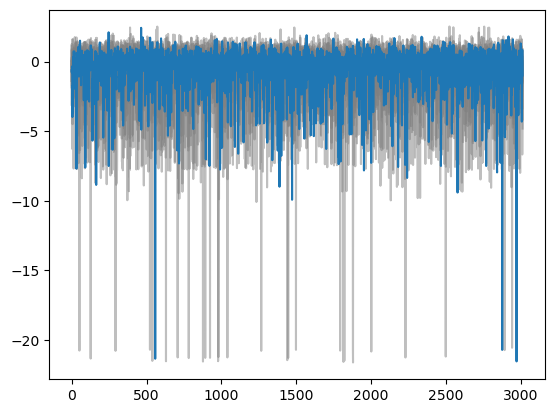

In [118]:
i_grid = 50

plt.figure()
plt.plot(pr_var_emus.sel(gridcell=i_grid).values.T, color="grey", alpha=0.5)
plt.plot(res_xr_flat.sel(gridcell=i_grid).values, color="C0")
plt.show()